# Amazon Food Review Analysis

### By: Greg Araya

For my third capstone, I wanted to explore sentiment analysis with data related to food. Crawling around the internet, I found this data set that has over 500K reviews on Amazon for some of their foods products. To take a look at the kaggle page follow this link: ["Amazon Fine Food Reviews"](https://www.kaggle.com/snap/amazon-fine-food-reviews)

This data was originally taken from this paper [From amateurs to connoisseurs: modeling the evolution of user expertise through online reviews](http://i.stanford.edu/~julian/pdfs/www13.pdf) written by J. McAuley and J. Leskovec, and includes:
- Reviews spanning about 13 years
- 568,454 total reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews


Using this data set I want to answer the following question: What are the most influential words in a review that predict whether it is positive or negative?

I plan to answer this question by using three models: Naive Bayes, Support Vector Classification, and Random Forests. Let's begin by importing in all the modules we're going to need.

In [62]:
# We can start importing everything we're going to need
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time

# Natural language processing modules
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Tools from scikit learn we can use on the models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

# Naive Bayes modules
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score

# Support Vector Classification
from sklearn.svm import LinearSVC

# Random Forest modules
from sklearn import tree
from sklearn import ensemble

# wordcloud module to make figures for a presentation
from wordcloud import WordCloud

First we'll query the sqlite server and get our data set into one main dataframe.

In [63]:
# Create a connection
conn = sqlite3.connect('database.sqlite')

# Create a cursor object that allows us to execute SQL queries on the database
curs = conn.cursor()

# Query the database
curs.execute('SELECT * FROM Reviews')

# Use the fetchall method to get all the results, and pandas to send it to a DataFrame for analysis
raw_data = pd.DataFrame(curs.fetchall())

# Assign our columns
raw_data.columns = ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 
                   'Score', 'Time', 'Summary', 'Text']

# Close the connection and cursor objects
curs.close()
conn.close()

Let's take a look at the data we pulled out.

In [64]:
raw_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


For this project I'd like to focus on the text used in the full comments, the overall score given, and the helpfulness scores, so I'm going to make a copy of this dataframe that only includes the columns that I'm interested in.

In [65]:
# Make a copy and display it
main_df = raw_data[['Score', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Text']].copy()

main_df.head()

,Score,HelpfulnessNumerator,HelpfulnessDenominator,Text
0,5,1,1,I have bought several of the Vitality canned d...
1,1,0,0,Product arrived labeled as Jumbo Salted Peanut...
2,4,1,1,This is a confection that has been around a fe...
3,2,3,3,If you are looking for the secret ingredient i...
4,5,0,0,Great taffy at a great price. There was a wid...


Now let's check and make sure we don't have any missing values that require our attention.

In [66]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 4 columns):
Score                     568454 non-null int64
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Text                      568454 non-null object
dtypes: int64(3), object(1)
memory usage: 17.3+ MB


Looks like all of our columns are filled out completely, and their data types make sense for what each column should contain. Let's move on with some visuals for the numerator columns and make sure there aren't other issues we might need to take care of, or at least be aware of.

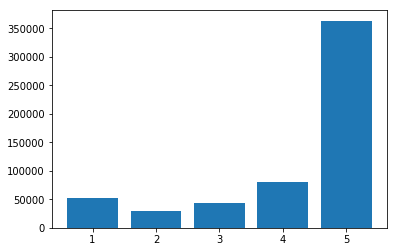

1     52268
2     29769
3     42640
4     80655
5    363122
Name: Score, dtype: int64


In [67]:
# Plot the number of times each score is found and print out the raw numbers
plt.bar(np.sort(main_df['Score'].unique()), main_df['Score'].value_counts(sort=False))
plt.show()
print(main_df['Score'].value_counts(sort=False))

Wow, apparently there are way more 5 star reviews than any other type of review (4.5 times as many as the next highest level in fact), so this is worth noting for our testing so that we can avoid skewing our models. Maybe we should get rid of scores that people have voted as "unhelpful". We can do this by creating a new column that calculates the percent of people who found the review to be helpful by dividing the "Helpfulness Numerator" by the "Helpfulness Denominator". This could potentially get rid of any fake reviews, or possibly help us find some errors.

In [68]:
# Create our new column for Helpfulness Percent
main_df['HelpPct'] = main_df['HelpfulnessNumerator'] / main_df['HelpfulnessDenominator']

# Since any reviews that have no helpfulness ratings will produce a NaN, fill these in with zero
main_df.fillna(value=0, inplace=True)

# Change this column to numeric instead of a string
main_df['HelpPct'] = pd.to_numeric(main_df['HelpPct'])

# Then print out some descriptive statistics
main_df['HelpPct'].describe()

count    568454.000000
mean          0.407862
std           0.462068
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: HelpPct, dtype: float64

Well that's strange, we got a max of 3 but we shouldn't have any percentages above a 1. How many of these reviews are there exactly? Let's see.

In [69]:
# Print out reviews with > 100% helpfulness percentage
main_df[main_df['HelpPct'] > 1].head()

,Score,HelpfulnessNumerator,HelpfulnessDenominator,Text,HelpPct
44736,4,3,2,It was almost a 'love at first bite' - the per...,1.5
64421,5,3,1,My son loves spaghetti so I didn't hesitate or...,3.0


Since there are only two of them, and they're both for scores in our biggest categories, we can easily drop these without losing much value.

In [70]:
# Drop these rows
main_df = main_df.drop(44736)
main_df = main_df.drop(64421)

Now let's see how many reviews got a helpfulness score of more than 50%, i.e. more people found it useful than not.

In [71]:
# Print out the # of reviews with > 50% helpfulness percentage
print('There are {} rows that match this requirement'.format(main_df[main_df['HelpPct'] > 0.5].shape[0]))

There are 226664 rows that match this requirement


Considering we still have over 226K reviews that got a helpfulness score of 50% or more, I think it's safe to base our models off of this data to avoid anything unhelpful and/or potentially fake.

In [72]:
# Only accept reviews with > 50% helpfulness
main_df = main_df[main_df['HelpPct'] > 0.5]

Now that our data is cleaned up a bit, let's create our categorical column that states if the review is positive or negative. I'm going to determine that a "good" review is one where the product gets 4 or more stars, since these are our two biggest categories, so for something to get 3 stars or lower, that seems like a decent drop in quality.

In [73]:
# Assign the sentiments to our new column according to our established rule
main_df.loc[main_df.Score < 4, 'Sentiment'] = 'Negative'

main_df.loc[main_df.Score >= 4, 'Sentiment'] = 'Positive'

Following this, let's get a count of how many values we get for each sentiment.

In [74]:
main_df['Sentiment'].value_counts()

Positive    182590
Negative     44074
Name: Sentiment, dtype: int64

Since we want a model that can make accurate predictions, we shouldn't feed it the dataframe as is. Since there is such a huge proportion of positive reviews, anybody could simply guess that the review is positive and be right about 80% of the time. This would look great to us initially, but would eventually produce bad results. So, let's take a subset of each sentiment such that we have the same number of each type. Let's say 44,000 for now. While we're at it, let's also sort by the reviews that have the highest helpfulness percent too.

In [75]:
# Sort by helpfulness percent, group by the score, and take the top 44,000
main_df_subset = main_df.sort_values('HelpPct', ascending=False).groupby('Sentiment').head(44_000)

# Then let's make sure we actually got the numbers we want as well
main_df_subset['Sentiment'].value_counts()

Positive    44000
Negative    44000
Name: Sentiment, dtype: int64

### Now this is where the fun begins, language processing.

Before I can create and test models, I need to clean up the text in the reviews just a bit more.

In [76]:
# Create a list of stop words, i.e. words that aren't useful, such as "and", "the", etc
s_words = stopwords.words("english")

# Next make a copy of our main dataframe so that we can play around with it without losing anything,
# in case we want or need it later. We only need the sentiments and review text anyways
procs_df = main_df_subset[['Sentiment', 'Text']].copy()

The code below creates a new column of "cleaned" reviews. It is applying a lambda function on each row. For each word in the row, we get rid of anything that isn't a-z or A-Z and substitute it with a space. Then, we split it up, get rid of words that aren't stop words, lowercase everything and join it back together.

In [77]:
# Create out cleaned column
procs_df['cleaned'] = procs_df['Text'].apply(lambda x: " ".join(
                                            w for w in re.sub("[^a-zA-Z]", " ", x).split() if w not in s_words).lower())

Now we can make our models and try to predict if the review is positive or negative. Since there are so many 4 and 5 star reviews, I'm going to choose a rating of 4 or more as my rule for determining something as "positive". Then I will test out three models: Naive Bayes, Support Vector Classification, and a Random Forest. Below I'll print out a slice of what the data looks like so far as well.

In [78]:
procs_df.head()

,Sentiment,Text,cleaned
0,Positive,I have bought several of the Vitality canned d...,i bought several vitality canned dog food prod...
359038,Positive,I received my case of Zico Coconut Water withi...,i received case zico coconut water within two ...
359040,Negative,I bought two cases of ZICO in the plastic bott...,i bought two cases zico plastic bottles so gro...
359041,Negative,First sip had me feeling sick! I'm not sure i...,first sip feeling sick i sure i like passion f...
359042,Negative,This is so gross. Zico should be ashamed!<br ...,this gross zico ashamed br br my reflex pulled...


### Naive Bayes

Let's start by finding our best parameters for a Naive Bayes model using cross validation, and then we can use those parameters on a split of training and testing data.

In [79]:
# Make a copy of the dataframe just for this model's testing so we can be sure its not affecting others
nb_df = procs_df.copy()

# Label our features and target
X = nb_df['cleaned']
Y = nb_df['Sentiment']

In [80]:
# Specify the distribution of parameters that we want to test
nb_prm_dist = dict(
    chi__k = [i for i in np.arange(1_000, 4_100, 100)],
    clf__alpha = [i for i in np.arange(0.1,1.1,0.1)], 
    clf__binarize = [i for i in np.arange(0.1,1.1,0.1)], 
    clf__fit_prior = [True, False]
    )

In [81]:
# Create a pipeline that will take us through the modeling process
nb_base_pipeline = Pipeline([
    # Use TfidfVectorizer and ngram_range = (1,2) to choose 1 and/or 2 words at a time
    ('vect', TfidfVectorizer(ngram_range=(1, 2), stop_words='english', sublinear_tf=True)),
    
    # Select the best features to train from using the chi squared algorithm
    ('chi', SelectKBest(chi2)),
    
    # Choose our classifier algorithm
    ('clf', BernoulliNB())
])

In [82]:
# Start a timer for the NB's CV search
nbcv_start_time = time.time()

# Set up the random search with our parameter distribution
nb_rand_search = RandomizedSearchCV(nb_base_pipeline, nb_prm_dist, n_iter=20, cv=10)

# Fit the random search to our data
nb_rand_search.fit(X, Y)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                       

With the cross validation completed, let's take a look at our best parameters.

In [83]:
print(nb_rand_search.best_params_)
print("The Naive Bayes' CV search took " + str(time.time() - nbcv_start_time) + " seconds")

{'clf__fit_prior': True, 'clf__binarize': 0.1, 'clf__alpha': 0.7000000000000001, 'chi__k': 3600}
The Naive Bayes' CV search took 3413.9193856716156 seconds


Now that we have our best parameters, we can use these as assigned variables and plug them into an updated pipeline that will work on split sets of the data for training and testing.

In [84]:
# Assign our best parameters to variables to use in an updated pipeline
nb_k = nb_rand_search.best_params_['chi__k']
nb_alpha = nb_rand_search.best_params_['clf__alpha']
nb_fit_prior = nb_rand_search.best_params_['clf__fit_prior']
nb_binarize = nb_rand_search.best_params_['clf__binarize']

In [85]:
# Split up our training and testing data, 20/80
X_train, X_test, y_train, y_test = train_test_split(nb_df['cleaned'], nb_df.Sentiment, test_size=0.2)

# Create a pipeline that will take us through the modeling process using our new parameters
nb_pipeline = Pipeline([
    # Use TfidfVectorizer and ngram_range = (1,2) to choose 1 and/or 2 words at a time
    ('vect', TfidfVectorizer(ngram_range=(1, 2), stop_words='english', sublinear_tf=True)),
    
    # Find the best features to train from using the chi squared algorithm
    ('chi', SelectKBest(chi2, k = nb_k)),
    
    # Choose our classifier algorithm
    ('clf', BernoulliNB(
                        alpha = nb_alpha, 
                        binarize = nb_binarize,
                        fit_prior = nb_fit_prior
                        )
    )
])

In [86]:
# Start a timer for the NB model
nb_start_time = time.time()

# Now we can fit our model to use for predictions
nb_model = nb_pipeline.fit(X_train, y_train)

In [87]:
# See how our model performs
print("The Naive Bayes model's accuracy on the test set is: " + str(nb_model.score(X_test, y_test)))
print("The Naive Bayes model took " + str(time.time() - nb_start_time) + " seconds")

The Naive Bayes model's accuracy on the test set is: 0.7921022727272727
The Naive Bayes model took 17.981623649597168 seconds


In [88]:
y_nb_true = nb_df['Sentiment']
y_nb_pred = nb_model.predict(nb_df['cleaned'])

print(classification_report(y_nb_true, y_nb_pred))

              precision    recall  f1-score   support

    Negative       0.85      0.69      0.76     44000
    Positive       0.74      0.88      0.80     44000

    accuracy                           0.78     88000
   macro avg       0.79      0.78      0.78     88000
weighted avg       0.79      0.78      0.78     88000



Looks like this did pretty well in some areas, and not as well in others, but overall good. Now that we have our first model running, and it produces a report for us, what exactly do those report columns actually mean?

#### Precision: 
- What percent of your predictions were correct?
- The ratio of true positives to the sum of true and false positives.

#### Recall:
- What percentage of the positive cases did you catch?
- The ratio of true positives to the sum of true positives and false negatives.

#### F1 score:
- What percent of positive predictions were correct?
- This is a weighted mean of precision and recall.

Following this, let's try out a few phrases that I made up just to see how it performs manually.

In [29]:
# Let's create a list of test phrases that I think are obviously positive or negative
rev_list = ['did not like this would not recommend', 'delightful food choice it was great', 'this was not great', 
           'worst meal I ever had', 'would recommend to everyone']

# Now print them out along with their predicted sentiment
for revw in rev_list:
    print("This review was predicted to be {}: {}".format(nb_model.predict([revw]), revw))

This review was predicted to be ['Negative']: did not like this would not recommend
This review was predicted to be ['Positive']: delightful food choice it was great
This review was predicted to be ['Positive']: this was not great
This review was predicted to be ['Negative']: worst meal I ever had
This review was predicted to be ['Positive']: would recommend to everyone


Looks like we were able to use this model to correctly categorize almost all of my made up reviews, except for the third one. I also tried increasing the ngram_range to (1, 3) for this model to see if that could help, but it actually made the model worse. Let's try another model and see if we can get some improvements. 

### Support Vector Classification

Here we'll repeat the same sort of process as we did for Naive Bayes, but this time using SVC.

In [30]:
# Make a copy of the dataframe just for this testing so we can be sure its not affecting others
svc_df = procs_df.copy()

# Label our features and target
X = svc_df['cleaned']
Y = svc_df['Sentiment']

In [31]:
# Specify the distribution of parameters that we want to test
svc_prm_dist = dict(
    chi__k = [i for i in np.arange(100, 2_600, 100)],
    clf__loss = ['hinge', 'squared_hinge'],
    clf__C = [i for i in np.arange(0.1,1.1,0.1)],
    clf__fit_intercept = [True, False],
    clf__max_iter = [i for i in np.arange(4_000, 6_100, 100)]
    )

In [32]:
# Create a base pipeline that will take us through the modeling process
svc_base_pipeline = Pipeline([
    # Use TfidfVectorizer and ngram_range = (1,2) to choose 1 and/or 2 words at a time
    ('vect', TfidfVectorizer(ngram_range=(1, 2), stop_words='english', sublinear_tf=True)),
    
    # Select the best features to train from using the chi squared algorithm
    ('chi', SelectKBest(chi2)),
    
    # Choose our classifier algorithm
    ('clf', LinearSVC(penalty = 'l2')) #'l2' is the standard in SVC
])

In [33]:
# Start a timer for the SVC's CV search
svccv_start_time = time.time()

# Set up the random search with our parameter distribution
svc_rand_search = RandomizedSearchCV(svc_base_pipeline, svc_prm_dist, n_iter=20, cv=10)

# Fit the random search to our data
svc_rand_search.fit(X, Y)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                       

In [34]:
print(svc_rand_search.best_params_)
print("The SVC's CV search took " + str(time.time() - svccv_start_time) + " seconds")

{'clf__max_iter': 5000, 'clf__loss': 'squared_hinge', 'clf__fit_intercept': False, 'clf__C': 1.0, 'chi__k': 2500}
The SVC's CV search took 3214.8602471351624 seconds


Again, now that we've found our best parameters, we can plug these into an updated pipeline and see how this approach performs.

In [35]:
# Assign our best parameters to variables to use in an updated pipeline
svc_k = svc_rand_search.best_params_['chi__k']
svc_loss = svc_rand_search.best_params_['clf__loss']
svc_C = svc_rand_search.best_params_['clf__C']
svc_fit_intercept = svc_rand_search.best_params_['clf__fit_intercept']
svc_max_iter = svc_rand_search.best_params_['clf__max_iter']

In [36]:
# Split up our training and testing data, 20/80
X_train, X_test, y_train, y_test = train_test_split(svc_df['cleaned'], svc_df.Sentiment, test_size=0.2)

# Create a pipeline that will take us through the modeling process
svc_pipeline = Pipeline([
    # Use TfidfVectorizer and ngram_range = (1,2) to choose 1 and/or 2 words at a time
    ('vect', TfidfVectorizer(ngram_range=(1, 2), stop_words='english', sublinear_tf=True)),
    
    # Select the best features to train from using the chi squared algorithm
    ('chi', SelectKBest(chi2, k = svc_k)),
    
    # Choose our classifier algorithm
    ('clf', LinearSVC(
                    C = svc_C, 
                    penalty = 'l2', #'l2' is the standard in SVC 
                    max_iter = svc_max_iter,
                    fit_intercept = svc_fit_intercept,
                    loss = svc_loss
                    ))
])

In [37]:
# Start a timer for the SVC model
svc_start_time = time.time()

# Now we can fit our model to use for predictions
svc_model = svc_pipeline.fit(X_train, y_train)

In [38]:
# See how our model performs
print("The Support Vector Classification model's accuracy on the test set is: " + str(svc_model.score(X_test, y_test)))
print("The Support Vector Classification model took " + str(time.time() - svc_start_time) + " seconds")

The Support Vector Classification model's accuracy on the test set is: 0.8639772727272728
The Support Vector Classification model took 15.400356531143188 seconds


In [39]:
y_svc_true = svc_df['Sentiment']
y_svc_pred = svc_model.predict(svc_df['cleaned'])

print(classification_report(y_svc_true, y_svc_pred))

              precision    recall  f1-score   support

    Negative       0.87      0.87      0.87     44000
    Positive       0.87      0.87      0.87     44000

    accuracy                           0.87     88000
   macro avg       0.87      0.87      0.87     88000
weighted avg       0.87      0.87      0.87     88000



Good news, Support Vector Classification did significantly better than the Naive Bayes model. It got a solid 87% in all of the classification report's metrics, and an overall accuracy score of 86.4%. It also took just about as much time to run through both processes (the cross validation and the final modeling), so if I had to stop here, SVC would be a clear winner. Why don't we run my manual sentences through this model like we did for Naive Bayes and see how that goes.

In [40]:
# Print out the predictions by this model from our previous review list
for revw in rev_list:
    print("This review was predicted to be {}: {}".format(svc_model.predict([revw]), revw))

This review was predicted to be ['Negative']: did not like this would not recommend
This review was predicted to be ['Positive']: delightful food choice it was great
This review was predicted to be ['Positive']: this was not great
This review was predicted to be ['Negative']: worst meal I ever had
This review was predicted to be ['Positive']: would recommend to everyone


Well unfortunately it didn't catch that third sentence again, but it did still get everything else correct. Let's do one more model and see what new metrics and results we can get out of that one.

### Random Forest

One more time, let's go through our cross validation and parameter plugging process, but this time using a Random Forest.

In [41]:
# Make a copy of the dataframe just for this testing so we can be sure its not affecting others
rafo_df = procs_df.copy()

# Label our features and target
X = rafo_df['cleaned']
Y = rafo_df['Sentiment']

In [42]:
# Specify the distribution of parameters that we want to test
rafo_prm_dist = dict(
    chi__k = [i for i in np.arange(1_000, 2_800, 100)],
    clf__n_estimators = [i for i in np.arange(30, 60, 5)],
    clf__criterion = ['gini', 'entropy'],
    clf__max_depth = [i for i in np.arange(40, 90, 5)],
    clf__max_features = ['auto', 'sqrt', 'log2']
    )

In [43]:
rafo_base_pipeline = Pipeline([
    # Use TfidfVectorizer and ngram_range = (1,2) to choose 1 and/or 2 words at a time
    ('vect', TfidfVectorizer(ngram_range=(1, 2), stop_words='english', sublinear_tf=True)),
    
    # Select the best features to train from using the chi squared algorithm
    ('chi', SelectKBest(chi2)),
    
    # Choose our classifier algorithm
    ('clf', ensemble.RandomForestClassifier())
])

In [44]:
# Start a timer for the random forest's CV search
rfcv_start_time = time.time()

# Set up the random search with our parameter distribution
rafo_rand_search = RandomizedSearchCV(rafo_base_pipeline, rafo_prm_dist, n_iter=10, cv=10)

# Fit the random search to our data
rafo_rand_search.fit(X, Y)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                       

In [45]:
print(rafo_rand_search.best_params_)
print("The Random Forest's CV search took " + str(time.time() - rfcv_start_time) + " seconds")

{'clf__n_estimators': 45, 'clf__max_features': 'log2', 'clf__max_depth': 75, 'clf__criterion': 'entropy', 'chi__k': 1100}
The Random Forest's CV search took 4258.7080228328705 seconds


Alright, we got some good parameters here, but you'll notice right off the bat it also took a MUCH longer time to get them. This is probably a CV search one would want to run over night, or at least while you get some dinner. Anyways, let's plug these parameters in and see how it performs.

In [46]:
# Assign our best parameteres to variables to use in an updated pipeline
rafo_k = rafo_rand_search.best_params_['chi__k']
rafo_n_estimators = rafo_rand_search.best_params_['clf__n_estimators']
rafo_criterion = rafo_rand_search.best_params_['clf__criterion']
rafo_max_depth = rafo_rand_search.best_params_['clf__max_depth']
rafo_max_features = rafo_rand_search.best_params_['clf__max_features']

In [47]:
# Split up our training and testing data, 20/80
X_train, X_test, y_train, y_test = train_test_split(rafo_df['cleaned'], rafo_df.Sentiment, test_size=0.2)

# Create a pipeline that will take us through the modeling process
rafo_pipeline = Pipeline([
    # Use TfidfVectorizer and ngram_range = (1,2) to choose 1 and/or 2 words at a time
    ('vect', TfidfVectorizer(ngram_range=(1, 2), stop_words='english', sublinear_tf=True)),
    
    # Select the best features to train from using the chi squared algorithm
    ('chi', SelectKBest(chi2, k = rafo_k)),
    
    # Choose our classifier algorithm
    ('clf', ensemble.RandomForestClassifier(
                                            n_estimators = rafo_n_estimators, 
                                            criterion = rafo_criterion,
                                            max_depth = rafo_max_depth,
                                            max_features = rafo_max_features
                                            ))
])

In [48]:
# Start a timer for the random forest
rf_start_time = time.time()

# Now we can fit our model to use for predictions
rafo_model = rafo_pipeline.fit(X_train, y_train)

In [49]:
# See how our model performs
print("The Random Forest Classification model's accuracy on the test set is: " + str(rafo_model.score(X_test, y_test)))
print("The Random Forest took " + str(time.time() - rf_start_time) + " seconds")

The Random Forest Classification model's accuracy on the test set is: 0.8626136363636364
The Random Forest took 29.64225697517395 seconds


In [50]:
y_rafo_true = rafo_df['Sentiment']
y_rafo_pred = rafo_model.predict(rafo_df['cleaned'])

print(classification_report(y_rafo_true, y_rafo_pred))

              precision    recall  f1-score   support

    Negative       0.95      0.92      0.94     44000
    Positive       0.93      0.95      0.94     44000

    accuracy                           0.94     88000
   macro avg       0.94      0.94      0.94     88000
weighted avg       0.94      0.94      0.94     88000



Wow, the Random Forest seems to perform even better than the SVC model by a decent margin. The big downfall unfortunately being that it also takes much longer to run through. The final model took twice as long, and the cross validation search took about 33% longer. Let's see how it performs on my arbitrary manual sentences to be sure it's working as we think.

In [51]:
# Print out the predictions by this model from our previous review list
for revw in rev_list:
    print("This review was predicted to be {}: {}".format(rafo_model.predict([revw]), revw))

This review was predicted to be ['Negative']: did not like this would not recommend
This review was predicted to be ['Positive']: delightful food choice it was great
This review was predicted to be ['Positive']: this was not great
This review was predicted to be ['Negative']: worst meal I ever had
This review was predicted to be ['Positive']: would recommend to everyone


Same results as before, which is somewhat discouraging on the surface, but I'll explain later why I think this may be occurring in my "weak points of this model" section. Otherwise it gets the job done.

### Word Clouds and Wrapping Up

Now that we've found our best model, I will finally look into which words are our best predictors of a positive or negative review. For this I've decided to look at the first 20 for each category and then place them into a word cloud. First however, I'll have to rerun some bits of earlier code so that we can pull out our best features.

In [113]:
# Perform each step of our pipeline, but save them to variables so we can use these to create and sort our list
tfvectorizer = rafo_model.named_steps['vect']
chi_test = rafo_model.named_steps['chi']
classifier = rafo_model.named_steps['clf']

# Get each word/feature
feature_list = tfvectorizer.get_feature_names()

# Use chi squared test to test each feature
feature_list = [feature_list[i] for i in chi_test.get_support(indices=True)]

# Set the features up as an array so we can sort them
feature_list = np.asarray(feature_list)

# Sort the features by how important they are
sort_coeffs = np.argsort(classifier.feature_importances_)


# Now make an array based on the sorted coefficients
sort_feats = feature_list[sort_coeffs]

# Flip the array around since they're currently from least to most important
sort_feats = sort_feats[::-1]

# Iterate through the list and place positive/negative words in appropriate lists
posi = 0
negi = 0
pos_list = []
neg_list = []


for word in sort_feats:
    if posi < 20:
        if rafo_model.predict([word]) == ['Positive']:
            pos_list.append(word)
            posi += 1
    if negi < 20:
        if rafo_model.predict([word]) == ['Negative']:
            neg_list.append(word)
            negi += 1

The code above created two lists of 20, one of our best features for Positive reviews, and the other with our best features for Negative reviews. Instead of printing them out into a boring list and reading them, let's look at some word clouds.

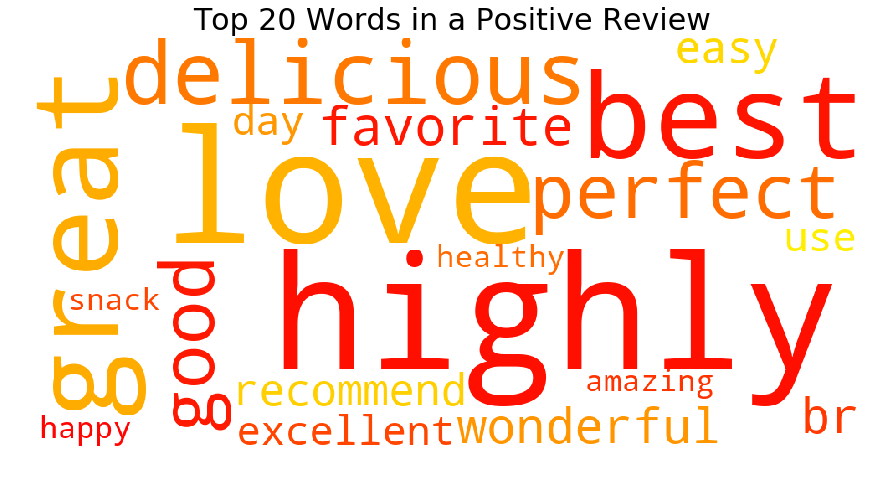

In [114]:
# Join our list into one using spaces
pos_cloud_string = (" ").join(pos_list)

# Create our wordcloud using the joined string as input
pos_wordcloud = WordCloud(width = 1000, height = 500, colormap='autumn', background_color='White').generate(pos_cloud_string)

# Choose the plot's size, pass it our the wordcloud, turn off the axis numbers, and show it
plt.figure(figsize=(15,8))
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.title('Top 20 Words in a Positive Review', fontsize=30)
plt.show()

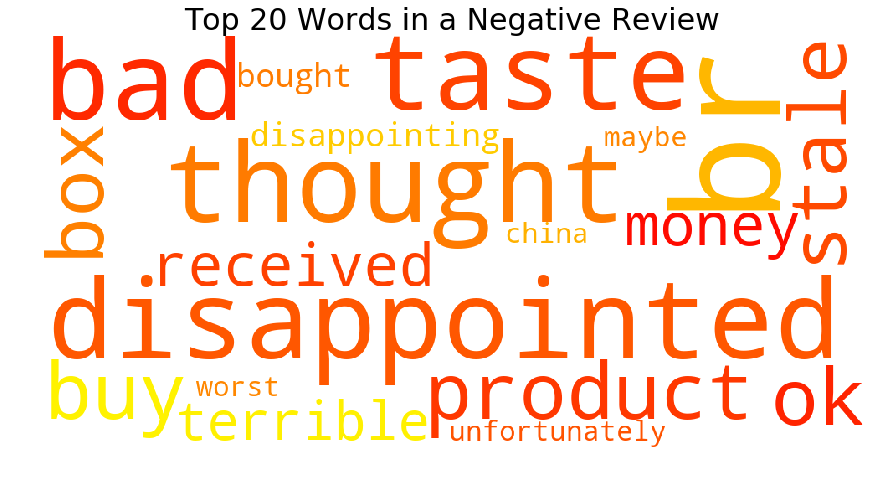

In [128]:
# Join our list into one using spaces
neg_cloud_string = (" ").join(neg_list)

# Create our wordcloud using the joined string as input
neg_wordcloud = WordCloud(width = 1000, height = 500, colormap='autumn', background_color='White').generate(neg_cloud_string)

# Choose the plot's size, pass it our the wordcloud, turn off the axis numbers, and show it
plt.figure(figsize=(15,8))
plt.imshow(neg_wordcloud)
plt.axis("off")
plt.title('Top 20 Words in a Negative Review', fontsize=30)
plt.show()

Intriguing results. But why would anybody want to run a model like this?

Practical uses of my model for an audience of interest:
1. Monitoring social media posts to see what people are saying about your brand as a whole.
2. Finding reviews in an automated way so that the company can address them more quickly.
3. See how specific products are doing and provide an automated way to find feedback management can use for decision making.
4. Provide data for market research.

Weak points or shortcomings of my model:
1. It was unable to pick up on my manually created review of "this was not great" that I thought as a human sounds negative. This may be due to the fact that "not great" seems to straddle the line between positive and negative, while "great" on its own indicates a highly positive review. For example, "not great" sometimes shows up in 4 star reviews as a reason why this person didn't reach for the full 5 stars. Ex: "I really enjoyed this product but the packaging was not great, so I deducted a star for that".
2. I didn't account for acronyms. For example, some people used "br" as a negative and others as a positive. Some of the reviews that I found this acronym in, it was saying they were leaving a "bad review", while others happily signed off with it, like saying "best regards".
3. Since I used a randomized search for cross validation, results were varied whenever I reran all of the models for any reason. Generally the order of best to worst model was the same though. I chose this method because it was much faster than doing a full grid search and allowed me to complete this capstone in the time permitted.

In conclusion, my Random Forest model was able to achieve a F-measure score of 94%, so we know that it is trustworthy. This model, or one like it, could be used to create business value in the following ways:

1. The output “Top Words” from could be used to find negative and positive reviews in an automated way.

2. These reviews could then be presented as market research for upper management to aid in proper decision making or shifts in tactics.

3. Negative reviews found could be sent to marketing teams to complete outreach tasks, such as offering replacements, refunds, and/or apologies on behalf of the company.

4. Positive reviews could be used to determine direction of certain products, or the brand as a whole